##**Import Dependencies**

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

##**Get the dataset**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
pip install -q kaggle

In [4]:
from google.colab import files

In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hiteshram","key":"84b8b18b3f09790f4d8eb814444ab6ba"}'}

In [6]:
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d cashutosh/gender-classification-dataset

 96% 259M/269M [00:01<00:00, 193MB/s]
100% 269M/269M [00:01<00:00, 165MB/s]


In [10]:
import zipfile
zip_ref = zipfile.ZipFile('/content/gender-classification-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [11]:
train_dir = '/content/Training'
val_dir = '/content/Validation'

In [12]:
train_dir_male = '/content/Training/male'
train_dir_female = '/content/Training/female'

val_dir_male = '/content/Validation/male'
val_dir_female = '/content/Validation/female'

print(f'Number of Male training Images: {len(os.listdir(train_dir_male))}')
print(f'Number of Female training Images: {len(os.listdir(train_dir_female))}')
print('======================================================================')
print(f'Number of Male validation Images: {len(os.listdir(val_dir_male))}')
print(f'Number of Male validation Images: {len(os.listdir(val_dir_female))}')

Number of Male training Images: 23766
Number of Female training Images: 23243
Number of Male validation Images: 5808
Number of Male validation Images: 5841


In [13]:
classes = os.listdir(train_dir)
classes

['male', 'female']

In [14]:
# Performing DataAugmentation
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range = 30,
    shear_range = 0.3,
    zoom_range = 0.3
)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [15]:
train_gen = train_datagen.flow_from_directory(train_dir,
                                              target_size = (250, 250),
                                              batch_size = 48,
                                              class_mode = 'binary')

Found 47009 images belonging to 2 classes.


In [16]:
valid_gen = test_datagen.flow_from_directory(val_dir,
                                             target_size = (250, 250),
                                             batch_size = 48,
                                             class_mode = 'binary')

Found 11649 images belonging to 2 classes.


In [17]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = transforms.Compose([
    transforms.Resize([64,64]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats, inplace = True)
])

valid_tfms = transforms.Compose([
    transforms.Resize([64,64]),
    transforms.ToTensor(),
    transforms.Normalize(*stats, inplace = True)
])

train_ds = ImageFolder(train_dir, transform = train_tfms)
val_ds = ImageFolder(val_dir, transform = valid_tfms)

In [18]:
BATCH_SIZE = 256

In [19]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle = True, num_workers = 3, pin_memory = True)
valid_dl = DataLoader(val_ds, BATCH_SIZE*2, num_workers = 3, pin_memory = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

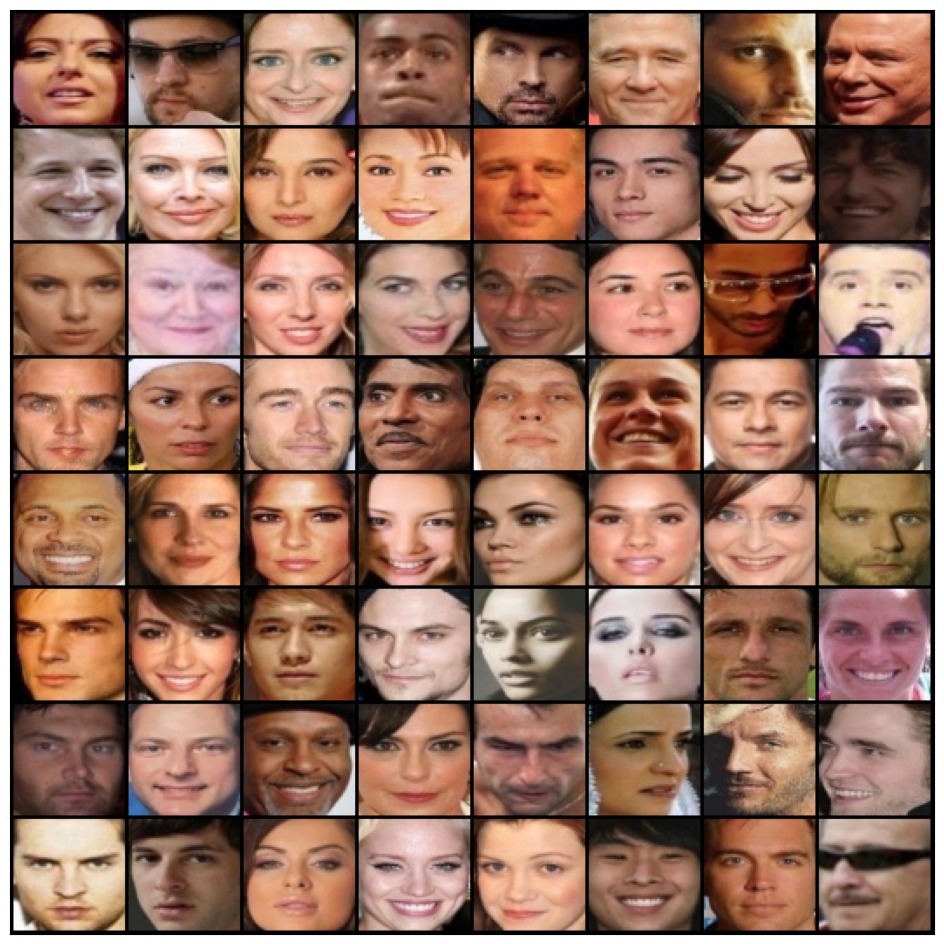

In [21]:
show_batch(train_dl)

In [22]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
     """Number of batches"""
     return len(self.dl)

In [23]:
device = get_default_device()
device

device(type='cuda')

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

train_dl, valid_dl

(<__main__.DeviceDataLoader at 0x7da9b0ef31c0>,
 <__main__.DeviceDataLoader at 0x7da9b0ef3430>)

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

##**Model Building**

In [26]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Resnet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64, pool=True)    # 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) # 128 x 16 x 16

        self.conv3 = conv_block(128, 256, pool=True) # 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True) # 512 X 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 512 x 4 x 4

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [27]:
model = to_device(Resnet9(3, 2), device)
model

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e

In [28]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [29]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 0.6938002109527588, 'val_acc': 0.503311812877655}]

In [30]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [31]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00394, train_loss: 0.2495, val_loss: 0.1387, val_acc: 0.9508
Epoch [1], last_lr: 0.00935, train_loss: 0.1741, val_loss: 0.1209, val_acc: 0.9576
Epoch [2], last_lr: 0.00972, train_loss: 0.1448, val_loss: 0.1271, val_acc: 0.9510
Epoch [3], last_lr: 0.00812, train_loss: 0.1161, val_loss: 0.0913, val_acc: 0.9666
Epoch [4], last_lr: 0.00556, train_loss: 0.1019, val_loss: 0.0982, val_acc: 0.9626
Epoch [5], last_lr: 0.00283, train_loss: 0.0851, val_loss: 0.0727, val_acc: 0.9730
Epoch [6], last_lr: 0.00077, train_loss: 0.0719, val_loss: 0.0719, val_acc: 0.9739
Epoch [7], last_lr: 0.00000, train_loss: 0.0527, val_loss: 0.0654, val_acc: 0.9757
CPU times: user 32.2 s, sys: 9.77 s, total: 42 s
Wall time: 6min 27s


In [31]:
torch.save(model.state_dict(), 'genderidentifier-resnet9.pth')

In [32]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs No. of epochs');

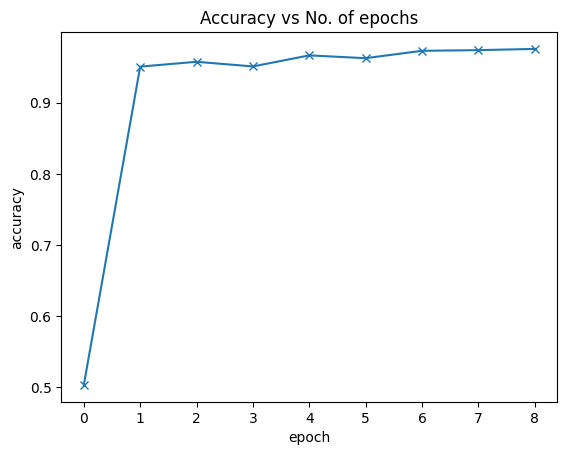

In [33]:
plot_accuracies(history)

In [34]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

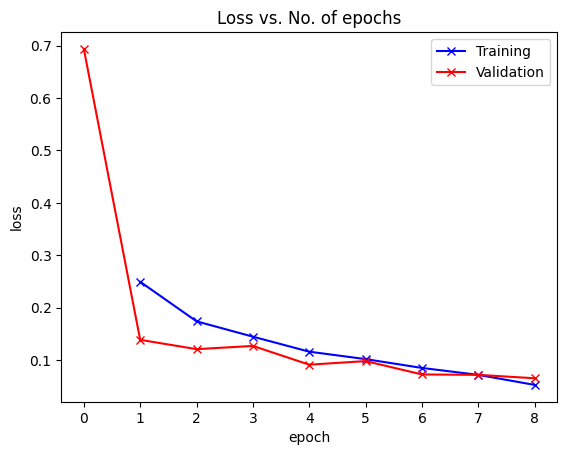

In [35]:
plot_losses(history)

In [36]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

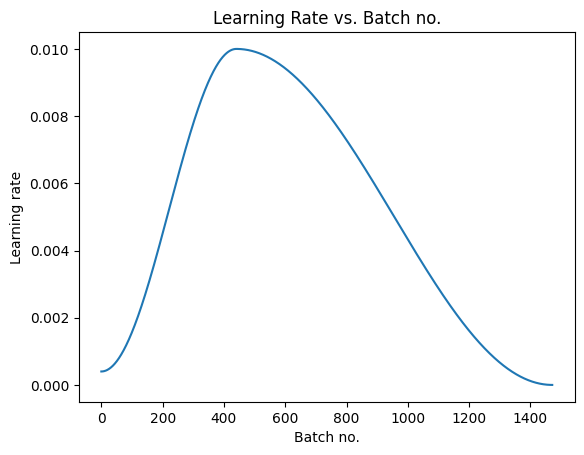

In [37]:
plot_lrs(history)

In [38]:
test_dataset = ImageFolder(val_dir, transform = valid_tfms)

In [39]:
def predict_img(img, model):
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  # Get predictions from model
  yb = model(xb)
  # Pick the index with highest probability
  _, pred = torch.max(yb, dim = 1)
  # Retrieve the class label
  return test_dataset.classes[pred[0].item()]

Label: female , Predicted: female


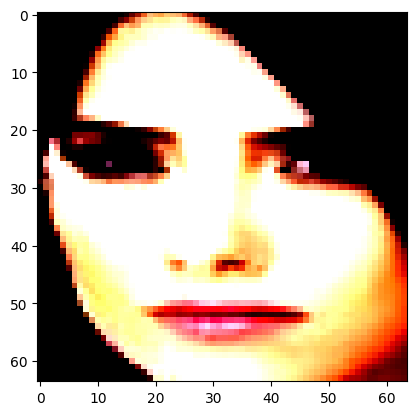

In [40]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_img(img, model))

Label: female , Predicted: female


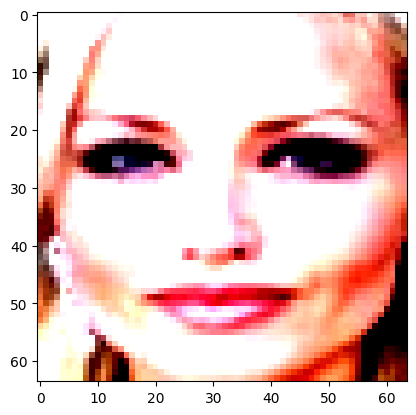

In [41]:
img, label = test_dataset[1000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_img(img, model))

Label: female , Predicted: female


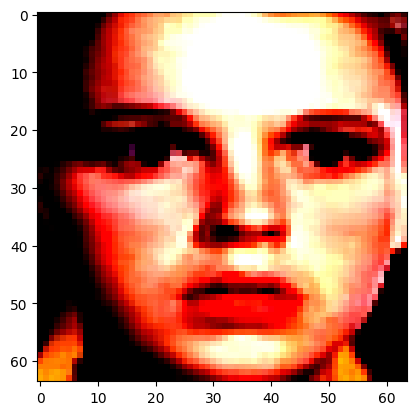

In [44]:
img, label = test_dataset[2098]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_img(img, model))

Label: male , Predicted: male


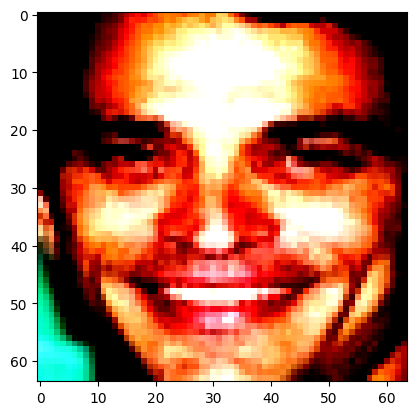

In [45]:
img, label = test_dataset[10000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_img(img, model))

Label: female , Predicted: female


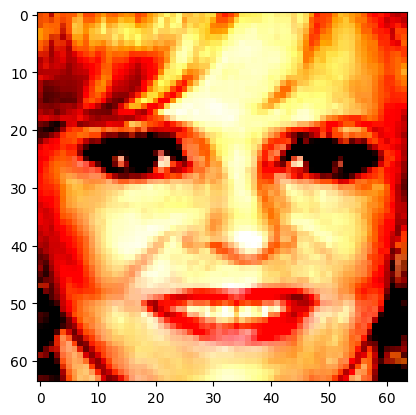

In [46]:
img, label = test_dataset[2398]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_img(img, model))